# MMF Machine Learning Project - Home Credit Default Risk

# Set Up

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from numpy.random import randint
from multiprocessing import cpu_count
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline #pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE #for feature selection
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import (f1_score,classification_report,accuracy_score,
                             roc_auc_score,confusion_matrix,roc_curve,auc) # evaluatin metrics
from sklearn.model_selection import KFold,RandomizedSearchCV ,cross_val_score,RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import gc

# Data Transformation

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("gdrive/MyDrive/MMF Machine Learning/home-credit-default-risk")

Mounted at /content/gdrive


In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)


    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [ ]:
# Reading the file
train = import_data('application_train.csv')
cash_balance = import_data ('credit_card_balance.csv')
bureau = import_data('bureau.csv')
previous = import_data('previous_application.csv')
POS = import_data('POS_CASH_balance.csv')
installment = import_data('installments_payments.csv')

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


## EDA

In [ ]:
pd.set_option('display.max_rows', 30)
def info(table):
    print(f'\n the shape of the table is : \n',table.shape)
    print('-' * 80)
    print('\n data types : ', table.dtypes.value_counts().sort_values())
    print('-' * 80)
    missings=table.isna().mean()[table.isna().mean().sort_values(ascending=False)!=0].sort_values(ascending=False)
    print('-' * 80)
    print('\n number of features having missing data : ',len(missings))
    print('-' * 80)
    print('\n missing data in the table: \n',missings)
    print('-' * 80)
    print(missings[missings>0.5])
    print('-' * 80)
    print('\n missing data over 50% : ',len(missings[missings>0.5]))
info(train)


 the shape of the table is : 
 (307511, 122)
--------------------------------------------------------------------------------

 data types :  int32       2
int16       2
float32     4
object     16
int8       37
float16    61
dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

 number of features having missing data :  67
--------------------------------------------------------------------------------

 missing data in the table: 
 COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
                              ...   
EXT_SOURCE_2                0.002146
AMT_GOODS_PRICE             0.000904
AMT_ANNUITY                 0.000039
CNT_FAM_MEMBERS             0.000007
DAYS_LAST_PHONE_CHANGE      0.000003
Length: 67, dtype: float64
-----

67 features missing some data, 41 features missing more than 50% of data

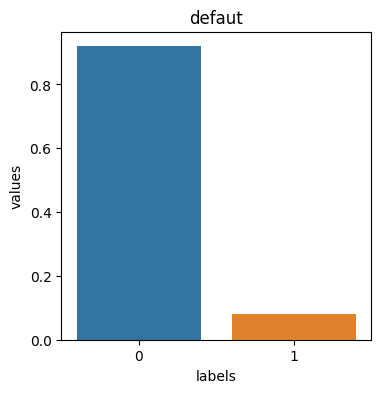

In [ ]:
temp = train.TARGET.value_counts()
df1 = pd.DataFrame({'labels': temp.index,
                   'values': temp.values/len(train)})
plt.figure(figsize = (4,4))
plt.title('defaut')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df1)
locs, labels = plt.xticks()
plt.show()

From the distribution plot of the TARGET column we notice than our data suffers from imbalanced classes , There are far more loans that were repaid on time than loans that were not repaid.This may affect the model and results in biased predictions toward the non default class.It's important to choose the right option to handle this issue before running model.

In [ ]:
def cat_stats(df, FEATURES):
    for feature in FEATURES:
        temp = df[feature].value_counts()
        df1 = pd.DataFrame({feature: temp.index, 'value': temp.values})
        cat_perc_0 = df[df['TARGET'] == 0].groupby(feature).size().reset_index(name='Count_Target_0')
        cat_perc_1 = df[df['TARGET'] == 1].groupby(feature).size().reset_index(name='Count_Target_1')
        cat_perc = cat_perc_0.merge(cat_perc_1, how='left', on=feature).fillna(0)
        cat_perc['Percentage_Target_0'] = cat_perc['Count_Target_0'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc['Percentage_Target_1'] = cat_perc['Count_Target_1'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc.sort_values(by=feature, inplace=True)

        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

        sns.set_palette("muted")

        # Plot distribution for TARGET == 0
        sns.barplot(ax=ax1, x=feature, y='Percentage_Target_0', data=cat_perc)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

        # Plot distribution for TARGET == 1
        sns.barplot(ax=ax2, x=feature, y='Percentage_Target_1', data=cat_perc)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.show()

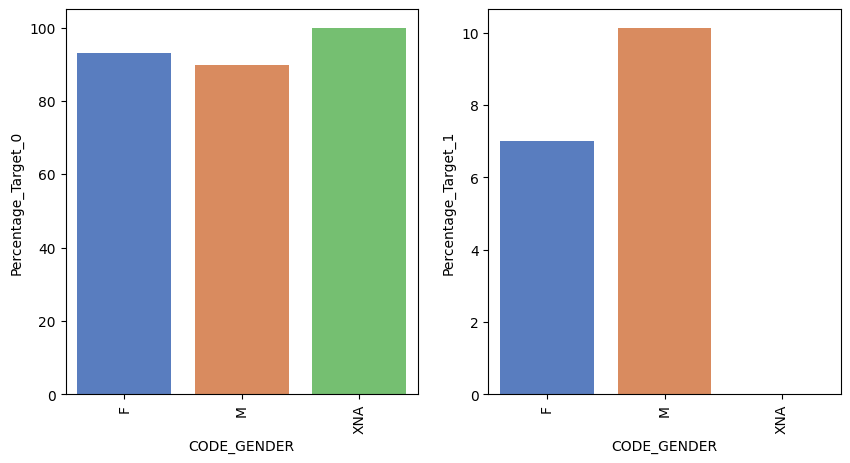

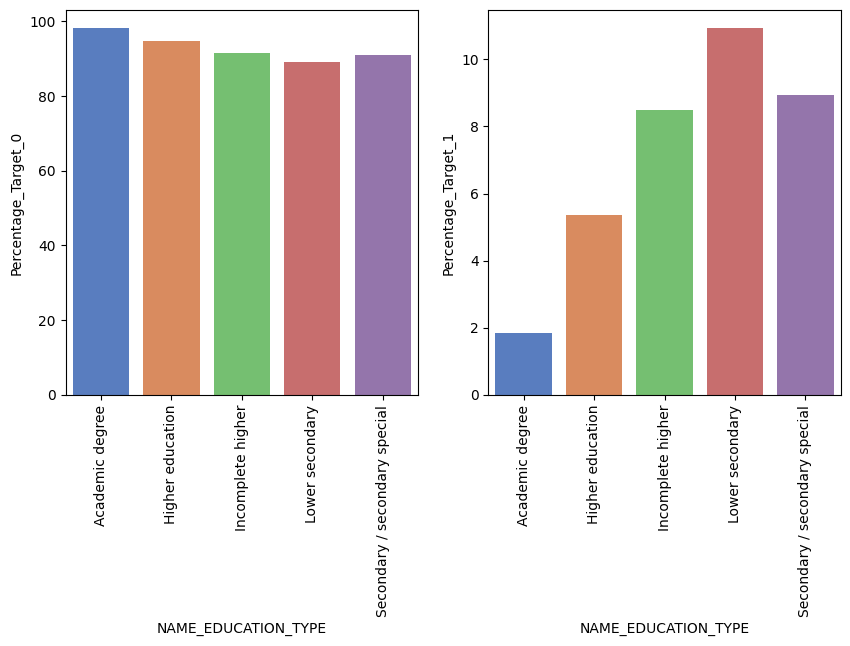

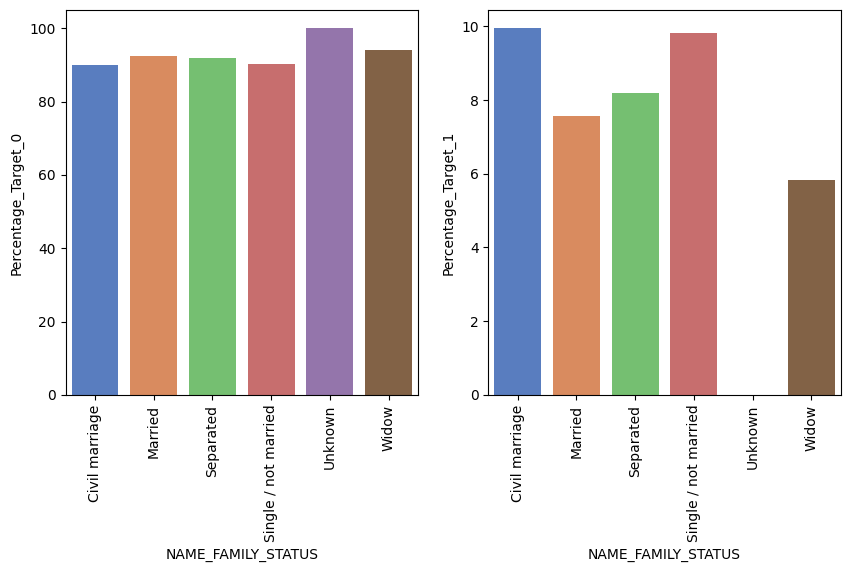

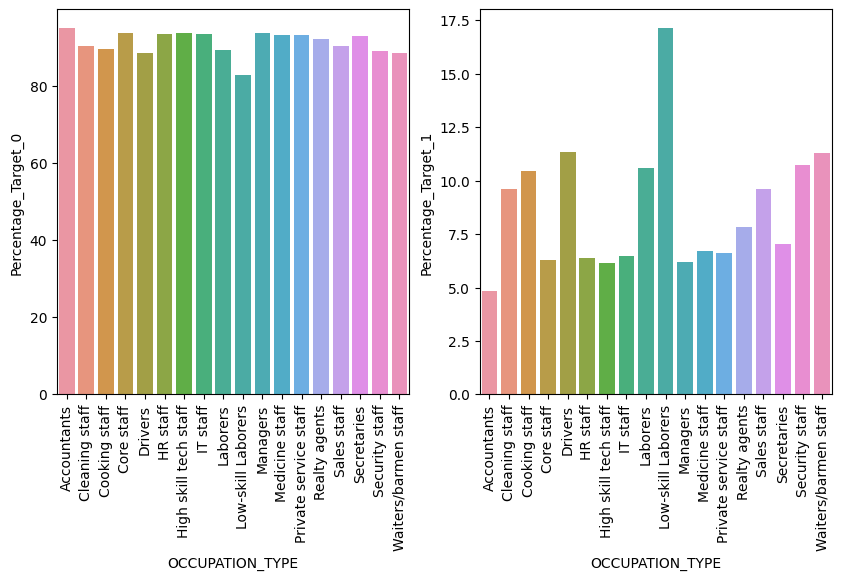

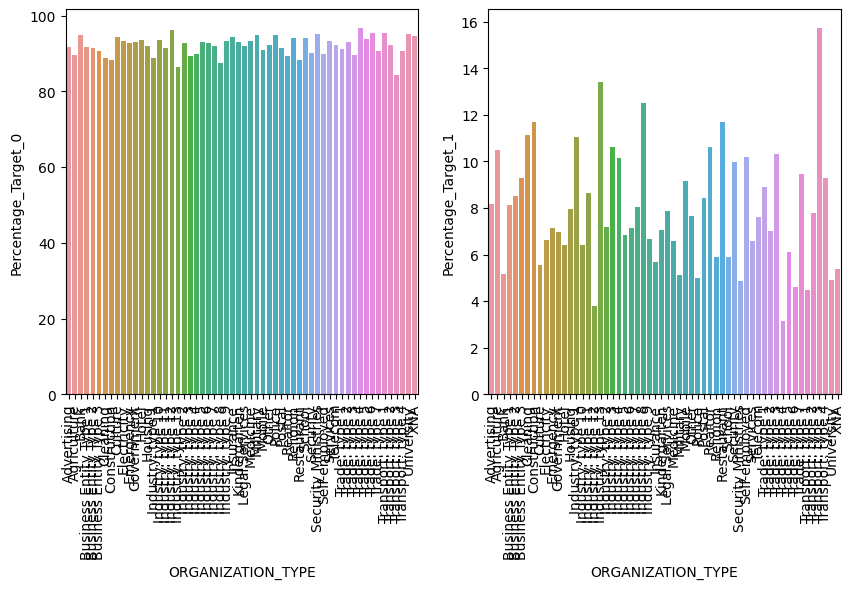

In [ ]:
important_categorical_features=['CODE_GENDER','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','OCCUPATION_TYPE',
'ORGANIZATION_TYPE']
cat_stats(train, important_categorical_features)

EDA above shows that Male has a higher default probability than Female. People with higher education backgrounds are less likely to default. Widow families have the lowest default rate compared to other families, and certain occupation / organization types seem to have low default probability.

In [ ]:
def chi2_test(df):
    chi2_stat_list=[]; p_val_list=[]; dof_list=[]; ex_list=[]
    for var in df.columns:
        chi2_stat, p_val, dof, ex = stats.chi2_contingency(pd.crosstab(train['TARGET'], train[var]))
        chi2_stat_list.append(chi2_stat); p_val_list.append(p_val); dof_list.append(dof); ex_list.append(ex);
    chi_squared=pd.DataFrame({'variable':df.columns,'DOF':dof_list,'Chi2 Stat':chi2_stat_list,'P-Value':p_val_list})
    chi_squared.set_index('variable',inplace=True)
    print(chi_squared.sort_values(by='P-Value',ascending=True))

chi2_test(train.select_dtypes('O'))

                            DOF    Chi2 Stat        P-Value
variable                                                   
ORGANIZATION_TYPE            57  1609.240636  5.224541e-299
OCCUPATION_TYPE              17  1402.846796  3.784500e-288
NAME_INCOME_TYPE              7  1253.470808  1.928146e-266
NAME_EDUCATION_TYPE           4  1019.213187  2.447681e-219
CODE_GENDER                   2   920.791334  1.129022e-200
NAME_FAMILY_STATUS            5   504.694083  7.744842e-107
NAME_HOUSING_TYPE             5   420.556190   1.099089e-88
NAME_CONTRACT_TYPE            1   293.150542   1.023515e-65
FLAG_OWN_CAR                  1   146.656018   9.330994e-34
WALLSMATERIAL_MODE            6   139.235314   1.453180e-27
HOUSETYPE_MODE                2    27.632556   9.992328e-07
EMERGENCYSTATE_MODE           1    23.678150   1.138680e-06
NAME_TYPE_SUITE               6    32.825315   1.132931e-05
FLAG_OWN_REALTY               1    11.575827   6.681470e-04
FONDKAPREMONT_MODE            3    16.80

EDA of categorical features show that significant features include ORGANIZATION_TYPE, OCCPUATION_TYPE, EDUCATION_TYPE, GENDER, etc..

## Feature Engineering

In [ ]:
#cash_balance[["MONTHS_BALANCE", "AMT_BALANCE"]] = cash_balance[["MONTHS_BALANCE", "AMT_BALANCE"]].apply(pd.to_numeric)


cash_balance_feats = cash_balance.groupby('SK_ID_CURR') \
  .apply(lambda x: pd.Series({
      'amt_balance': x['AMT_BALANCE'].sum(),
      'amt_balance_0_1_year': x['AMT_BALANCE'][x['MONTHS_BALANCE'] >= -12].sum(),
      'amt_balance_1_2_year': x['AMT_BALANCE'][(x['MONTHS_BALANCE'] < -12) & (x['MONTHS_BALANCE'] >= -24)].sum()
  })
)

In [ ]:
cash_balance_feats.head()

,amt_balance,amt_balance_0_1_year,amt_balance_1_2_year
SK_ID_CURR,,,
100006,0.00,0.0,0.0
100011,4031676.25,0.0,0.0
100013,1743352.25,0.0,0.0
100021,0.00,0.0,0.0
100023,0.00,0.0,0.0


In [ ]:
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg([np.mean]).reset_index()

# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':

        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns

In [ ]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_mean,bureau_CREDIT_DAY_OVERDUE_mean,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_ENDDATE_FACT_mean,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_CNT_CREDIT_PROLONG_mean,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_DAYS_CREDIT_UPDATE_mean,bureau_AMT_ANNUITY_mean
0,100001,-735.000000,0.0,82.428574,-825.500000,NaN,0.0,207623.578125,85240.929688,0.000000,0.0,-93.142857,3545.357178
1,100002,-874.000000,0.0,-349.000000,-697.500000,1681.028931,0.0,108131.945312,49156.199219,7997.141113,0.0,-499.875000,0.000000
2,100003,-1400.750000,0.0,-544.500000,-1097.666626,0.000000,0.0,254350.125000,0.000000,202500.000000,0.0,-816.000000,NaN
3,100004,-867.000000,0.0,-488.500000,-532.500000,0.000000,0.0,94518.898438,0.000000,0.000000,0.0,-532.000000,NaN
4,100005,-190.666667,0.0,439.333344,-123.000000,0.000000,0.0,219042.000000,189469.500000,0.000000,0.0,-54.333333,1420.500000


In [ ]:
previous_agg = previous.drop(columns = ['SK_ID_PREV']).groupby('SK_ID_CURR', as_index = False).agg([np.mean]).reset_index()

# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in previous_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':

        # Iterate through the stat names
        for stat in previous_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('previous_%s_%s' % (var, stat))

# Assign the list of columns names as the dataframe column names
previous_agg.columns = columns

In [ ]:
previous_agg.head()

,SK_ID_CURR,previous_AMT_ANNUITY_mean,previous_AMT_APPLICATION_mean,previous_AMT_CREDIT_mean,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_GOODS_PRICE_mean,previous_HOUR_APPR_PROCESS_START_mean,previous_NFLAG_LAST_APPL_IN_DAY_mean,previous_RATE_DOWN_PAYMENT_mean,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIVILEGED_mean,previous_DAYS_DECISION_mean,previous_SELLERPLACE_AREA_mean,previous_CNT_PAYMENT_mean,previous_DAYS_FIRST_DRAWING_mean,previous_DAYS_FIRST_DUE_mean,previous_DAYS_LAST_DUE_1ST_VERSION_mean,previous_DAYS_LAST_DUE_mean,previous_DAYS_TERMINATION_mean,previous_NFLAG_INSURED_ON_APPROVAL_mean
0,100001,3951.000000,24835.50,23787.00,2520.0,24835.5,13.000000,1.0,0.104309,NaN,NaN,-1740.0,23.0,8.0,365243.0,-1709.000000,-1499.000000,-1619.000000,-1612.000000,0.000000
1,100002,9251.775391,179055.00,179055.00,0.0,179055.0,9.000000,1.0,0.000000,NaN,NaN,-606.0,500.0,24.0,365243.0,-565.000000,125.000000,-25.000000,-17.000000,0.000000
2,100003,56553.988281,435436.50,484191.00,3442.5,435436.5,14.666667,1.0,0.050018,NaN,NaN,-1305.0,533.0,10.0,365243.0,-1274.333374,-1004.333313,-1054.333374,-1047.333374,0.666667
3,100004,5357.250000,24282.00,20106.00,4860.0,24282.0,5.000000,1.0,0.212036,NaN,NaN,-815.0,30.0,4.0,365243.0,-784.000000,-694.000000,-724.000000,-714.000000,0.000000
4,100005,4813.200195,22308.75,20076.75,4464.0,44617.5,10.500000,1.0,0.108948,NaN,NaN,-536.0,18.0,12.0,365243.0,-706.000000,-376.000000,-466.000000,-460.000000,0.000000


In [ ]:
POS_feats = POS.groupby('SK_ID_CURR') \
  .apply(lambda x: pd.Series({
      'CNT_INSTALMENT': x['CNT_INSTALMENT'].sum(),
      'CNT_INSTALMENT_0_1_year': x['CNT_INSTALMENT'][x['MONTHS_BALANCE'] >= -12].sum(),
      'CNT_INSTALMENT_1_2_year': x['CNT_INSTALMENT'][(x['MONTHS_BALANCE'] < -12) & (x['MONTHS_BALANCE'] >= -24)].sum()
  })
)

In [ ]:
POS_feats.head()

,CNT_INSTALMENT,CNT_INSTALMENT_0_1_year,CNT_INSTALMENT_1_2_year
SK_ID_CURR,,,
100001,36.0,0.0,0.0
100002,456.0,288.0,168.0
100003,283.0,0.0,103.0
100004,15.0,0.0,3.0
100005,117.0,0.0,117.0


In [ ]:
installment_agg = installment.drop(columns = ['SK_ID_PREV']).groupby('SK_ID_CURR', as_index = False).agg([np.mean]).reset_index()

# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in installment_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':

        # Iterate through the stat names
        for stat in installment_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('installment_%s_%s' % (var, stat))

# Assign the list of columns names as the dataframe column names
installment_agg.columns = columns

In [ ]:
installment_agg.head()

,SK_ID_CURR,installment_NUM_INSTALMENT_VERSION_mean,installment_NUM_INSTALMENT_NUMBER_mean,installment_DAYS_INSTALMENT_mean,installment_DAYS_ENTRY_PAYMENT_mean,installment_AMT_INSTALMENT_mean,installment_AMT_PAYMENT_mean
0,100001,1.142857,2.714286,-2187.714355,-2195.142822,5885.132324,5885.132324
1,100002,1.052632,10.000000,-295.000000,-315.421051,11559.247070,11559.247070
2,100003,1.040000,5.080000,-1378.160034,-1385.359985,64754.585938,64754.585938
3,100004,1.333333,2.000000,-754.000000,-761.666687,7096.154785,7096.154785
4,100005,1.111111,5.000000,-586.000000,-609.555542,6240.205078,6240.205078


In [ ]:
#from functools import reduce

#dataframes = [train, cash_balance_feats, bureau_agg, previous_agg, POS_feats, installment_agg]

#data_merged = reduce(lambda left,right: pd.merge(left,right,on='SK_ID_CURR'), dataframes)

In [ ]:
from functools import reduce

dataframes = [train, cash_balance_feats, bureau_agg, previous_agg, POS_feats, installment_agg]

# Function to perform left join
def left_join_dfs(left, right):
    return pd.merge(left, right, on='SK_ID_CURR', how='left')

# Merging all dataframes with a left join
data_merged = reduce(left_join_dfs, dataframes)

In [ ]:
data_merged.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,previous_NFLAG_INSURED_ON_APPROVAL_mean,CNT_INSTALMENT,CNT_INSTALMENT_0_1_year,CNT_INSTALMENT_1_2_year,installment_NUM_INSTALMENT_VERSION_mean,installment_NUM_INSTALMENT_NUMBER_mean,installment_DAYS_INSTALMENT_mean,installment_DAYS_ENTRY_PAYMENT_mean,installment_AMT_INSTALMENT_mean,installment_AMT_PAYMENT_mean
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.000000,456.0,288.0,168.0,1.052632,10.000000,-295.000000,-315.421051,11559.247070,11559.247070
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.666667,283.0,0.0,103.0,1.040000,5.080000,-1378.160034,-1385.359985,64754.585938,64754.585938
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.000000,15.0,0.0,3.0,1.333333,2.000000,-754.000000,-761.666687,7096.154785,7096.154785
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.000000,240.0,170.0,70.0,1.125000,4.437500,-252.250000,-271.625000,62947.089844,62947.089844
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.600000,1012.0,322.0,218.0,1.166667,7.045455,-1028.606079,-1032.242432,12666.444336,12214.059570


In [ ]:
data_merged.dtypes

SK_ID_CURR                                  int32
TARGET                                       int8
NAME_CONTRACT_TYPE                         object
CODE_GENDER                                object
FLAG_OWN_CAR                               object
                                           ...   
installment_NUM_INSTALMENT_NUMBER_mean    float64
installment_DAYS_INSTALMENT_mean          float32
installment_DAYS_ENTRY_PAYMENT_mean       float32
installment_AMT_INSTALMENT_mean           float32
installment_AMT_PAYMENT_mean              float32
Length: 165, dtype: object

In [ ]:
data_merged.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,previous_NFLAG_INSURED_ON_APPROVAL_mean,CNT_INSTALMENT,CNT_INSTALMENT_0_1_year,CNT_INSTALMENT_1_2_year,installment_NUM_INSTALMENT_VERSION_mean,installment_NUM_INSTALMENT_NUMBER_mean,installment_DAYS_INSTALMENT_mean,installment_DAYS_ENTRY_PAYMENT_mean,installment_AMT_INSTALMENT_mean,installment_AMT_PAYMENT_mean
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,289760.000000,289444.0,289444.0,289444.0,291643.000000,291643.000000,291643.000000,291635.000000,2.916430e+05,2.916350e+05
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990259e+05,27108.572266,5.383961e+05,0.000000,-16036.995067,63815.045904,...,0.277792,NaN,NaN,NaN,1.041501,9.764795,-909.662231,-920.961365,1.839261e+04,1.875431e+04
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737305,3.694465e+05,0.000000,4363.988632,141275.766519,...,0.317595,NaN,NaN,NaN,0.602107,11.273675,598.461487,597.024902,2.333797e+04,2.510536e+04
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.0,0.0,0.0,0.000000,1.000000,-2922.000000,-3072.000000,0.000000e+00,1.890000e-01
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010010,-19682.000000,-2760.000000,...,0.000000,126.0,0.0,0.0,1.000000,4.555556,-1301.967407,-1311.825195,7.799513e+03,7.478371e+03
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018845,-15750.000000,-1213.000000,...,0.200000,288.0,72.0,51.0,1.017241,6.045455,-795.944458,-807.581848,1.257265e+04,1.222576e+04
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028656,-12413.000000,-289.000000,...,0.500000,660.0,216.0,186.0,1.111111,9.434413,-419.000000,-431.609955,2.137614e+04,2.135287e+04
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072510,-7489.000000,365243.000000,...,1.000000,7812.0,2304.0,2268.0,39.000000,138.110063,-3.000000,-3.000000,2.504590e+06,2.504590e+06


In [ ]:
data_merged.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
307506    False
307507    False
307508    False
307509    False
307510    False
Length: 307511, dtype: bool

In [ ]:
# checking missing data
total_null = data_merged.isnull().count()
percent = (data_merged.isnull().sum()/data_merged.isnull().count()*100)
missing_check  = pd.concat([total_null, percent], axis=1, keys=['Total Null', 'Percent']).sort_values(ascending = False, by = ['Percent'])
missing_check.head(10)

,Total Null,Percent
previous_RATE_INTEREST_PRIMARY_mean,307511,98.501192
previous_RATE_INTEREST_PRIVILEGED_mean,307511,98.501192
bureau_AMT_ANNUITY_mean,307511,73.981744
amt_balance_1_2_year,307511,71.739222
amt_balance_0_1_year,307511,71.739222
amt_balance,307511,71.739222
COMMONAREA_AVG,307511,69.872297
COMMONAREA_MODE,307511,69.872297
COMMONAREA_MEDI,307511,69.872297
NONLIVINGAPARTMENTS_MODE,307511,69.432963


In [ ]:
missing_ratios = data_merged.isnull().mean()

cols_to_drop = missing_ratios[missing_ratios > 0.6].index

data_cleaned = data_merged.drop(columns=cols_to_drop)

In [ ]:
# Summing up the 20 flag document features into one feature, reducing sparsity of data
FLAG_DOCUMENTS = ['FLAG_DOCUMENT_2',
'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']
data_cleaned['FLAG_DOCUMENT'] = data_cleaned[FLAG_DOCUMENTS].sum(axis=1)
data_cleaned.drop(FLAG_DOCUMENTS, axis=1, inplace=True)

More feature generation

In [ ]:
# AGE
data_cleaned['AGE'] = data_cleaned['DAYS_BIRTH']/(-365) # original data negative
# MEAN_EXT_SOURCE
data_cleaned['MEAN_EXT_SOURCE'] = data_cleaned[['EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
# YEARS_EMPLOYED
data_cleaned['YEARS_EMPLOYED']=data_cleaned['DAYS_EMPLOYED']/(-365)
# DEBT_TO_INCOME_RATIO
data_cleaned['DEBT_TO_INCOME_RATIO'] = data_cleaned['AMT_CREDIT'] / data_cleaned['AMT_INCOME_TOTAL']
# INCOME_TO_CREDIT
data_cleaned['INCOME_TO_CREDIT'] = data_cleaned['AMT_INCOME_TOTAL'] / data_cleaned['AMT_CREDIT']
# Credit Utilization Ratio
# data_cleaned['CREDIT_UTILIZATION_RATIO'] = data_cleaned['AMT_BALANCE'] / data_cleaned['AMT_CREDIT_LIMIT_ACTUAL']
# Loan Value Ratio: Ratio of the loan amount to the goods price.
# This can indicate how much coverage the loan amount has over the item being purchased.
data_cleaned['LOAN_VALUE_RATIO'] = data_cleaned['AMT_CREDIT'] / data_cleaned['AMT_GOODS_PRICE']
# IF total income is higher than average
data_cleaned['IS_INCOME_ABOVE_AVERAGE'] = (data_cleaned['AMT_INCOME_TOTAL'] > data_cleaned['AMT_INCOME_TOTAL'].mean()).astype(int)

In [ ]:
# Indicator Features
data_cleaned['INCOME_LEVEL'] = pd.qcut(data_cleaned['AMT_INCOME_TOTAL'],3,labels=['Low_INCOME', 'Medium_INCOME', 'High_INCOME'])
data_cleaned['ANNUITY_LEVEL'] = pd.qcut(data_cleaned['AMT_ANNUITY'],3,labels=['Low_ANNUITY', 'Medium_ANNUITY', 'High_ANNUITY'])
# If goods price within a certain range
data_cleaned['AMT_GOODS_PRICE_LEVEL'] = np.where((data_cleaned['AMT_GOODS_PRICE']<= 60000) & (data_cleaned['AMT_GOODS_PRICE']>=10000) ,1,0)
data_cleaned['CREDIT_UNDER_100K'] = np.where(data_cleaned['AMT_CREDIT']<100000,1,0)
# A binary feature to identify retirees
data_cleaned['IS_RETIRE'] = (data_cleaned['NAME_INCOME_TYPE'] == 'Pensioner').astype(int)

In [ ]:
# #one-hot encode the categorical variables

# data_factorized = pd.get_dummies(data_cleaned)


# #let's pad the rest with 0's (for now)
# #clean up infinite values also - just in case
# data_factorized.replace([np.inf, -np.inf], np.nan)

# for col in list(data_factorized.columns):
#     data_factorized[col].fillna(0, inplace = True)

In [ ]:
missing_ratios = data_cleaned.isnull().mean()

cols_to_drop = missing_ratios[missing_ratios > 0.6].index

data_cleaned = data_cleaned.drop(columns=cols_to_drop)

In [ ]:
data_cleaned.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,YEARS_EMPLOYED,DEBT_TO_INCOME_RATIO,INCOME_TO_CREDIT,LOAN_VALUE_RATIO,IS_INCOME_ABOVE_AVERAGE,INCOME_LEVEL,ANNUITY_LEVEL,AMT_GOODS_PRICE_LEVEL,CREDIT_UNDER_100K,IS_RETIRE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.745205,2.007889,0.498036,1.158397,1,High_INCOME,Medium_ANNUITY,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,3.254795,4.790750,0.208736,1.145199,1,High_INCOME,High_ANNUITY,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.616438,2.000000,0.500000,1.000000,0,Low_INCOME,Low_ANNUITY,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,8.326027,2.316167,0.431748,1.052803,0,Medium_INCOME,Medium_ANNUITY,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,8.323288,4.222222,0.236842,1.000000,0,Medium_INCOME,Medium_ANNUITY,0,0,0


remove highy missing columns

## Select important features

In [ ]:
X = data_cleaned.select_dtypes(include=['number']).drop(columns=['SK_ID_CURR', 'TARGET'])
y = data_cleaned['TARGET']

In [ ]:
# Replace Missing values for Numerical Features
X_numerical = X.select_dtypes(include=['number'])

# Replace infinite values with NaN
X_numerical.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_numerical)

Get best 100 numerical features based on ANOVA variable significance test

In [ ]:
selector = SelectKBest(f_classif, k=100)
X_new = selector.fit_transform(X_imputed, y)

# Get the selected feature names
selected_features = X_numerical.columns[selector.get_support(indices=True)]
selected_feature_list = selected_features.tolist()

# Print selected feature names
selected_feature_list

['CNT_CHILDREN',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LANDAREA_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LANDAREA_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'ELEVATORS_MEDI',
 

In [ ]:
# Replace Missing values for Categorical Features
X_categorical = data_cleaned.select_dtypes(include=['object'])

# Impute missing values in categorical data
# Here we use the most frequent value (mode) for imputation
cat_imputer = SimpleImputer(strategy='most_frequent')
X_categorical_imputed = cat_imputer.fit_transform(X_categorical)

In [ ]:
# Convert the imputed array back to a pandas DataFrame
X_categorical_imputed_df = pd.DataFrame(X_categorical_imputed, columns=X_categorical.columns, index=X_categorical.index)
X_categorical_encoded = pd.get_dummies(X_categorical_imputed_df, dummy_na=False)
#X_numerical_imputed_df = pd.DataFrame(X_imputed, columns=X_numerical.columns, index=X_numerical.index)
X_numerical_imputed_df = pd.DataFrame(X_new, columns=selected_features, index=data_cleaned.index)
data_factorized = pd.concat([X_numerical_imputed_df, X_categorical_encoded], axis=1)

QA

In [ ]:
data_factorized.head()

,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0.0,406597.5,24700.5,351000.0,0.018799,-9461.0,-637.0,-3648.0,-2120.0,1.0,...,0,0,0,0,0,0,1,0,1,0
1,0.0,1293502.5,35698.5,1129500.0,0.003542,-16765.0,-1188.0,-1186.0,-291.0,1.0,...,0,1,0,0,0,0,0,0,1,0
2,0.0,135000.0,6750.0,135000.0,0.010033,-19046.0,-225.0,-4260.0,-2531.0,1.0,...,0,0,0,0,0,1,0,0,1,0
3,0.0,312682.5,29686.5,297000.0,0.008018,-19005.0,-3039.0,-9832.0,-2437.0,1.0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,513000.0,21865.5,513000.0,0.028656,-19932.0,-3038.0,-4312.0,-3458.0,1.0,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
data_factorized.describe()

,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
count,307511.000000,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.417052,5.990260e+05,27108.487841,5.383163e+05,0.020870,-16036.995067,63815.045904,-4986.117391,-2994.202373,0.819889,...,0.003941,0.030090,0.007466,0.005785,0.005284,0.723164,0.210773,0.017437,0.992430,0.007570
std,0.722121,4.024908e+05,14493.461065,3.692890e+05,0.013833,4363.988632,141275.766519,3522.882210,1509.450419,0.384280,...,0.062656,0.170835,0.086085,0.075840,0.072501,0.447435,0.407858,0.130892,0.086679,0.086679
min,0.000000,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.700000e+05,16524.000000,2.385000e+05,0.010010,-19682.000000,-2760.000000,-7480.000000,-4299.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,5.135310e+05,24903.000000,4.500000e+05,0.018845,-15750.000000,-1213.000000,-4504.000000,-3254.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,8.086500e+05,34596.000000,6.795000e+05,0.028656,-12413.000000,-289.000000,-2010.000000,-1720.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,19.000000,4.050000e+06,258025.500000,4.050000e+06,0.072510,-7489.000000,365243.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
data_factorized.dtypes

CNT_CHILDREN                       float64
AMT_CREDIT                         float64
AMT_ANNUITY                        float64
AMT_GOODS_PRICE                    float64
REGION_POPULATION_RELATIVE         float64
                                    ...   
WALLSMATERIAL_MODE_Panel             uint8
WALLSMATERIAL_MODE_Stone, brick      uint8
WALLSMATERIAL_MODE_Wooden            uint8
EMERGENCYSTATE_MODE_No               uint8
EMERGENCYSTATE_MODE_Yes              uint8
Length: 236, dtype: object

# Train Test Split

In [ ]:
#X_train = data_factorized.drop(['SK_ID_CURR', 'TARGET'], axis = 1)
#y_train = data_factorized['TARGET']

In [ ]:
data_factorized['TARGET'] = y

data_0 = data_factorized[data_factorized['TARGET'] == 0]
data_1 = data_factorized[data_factorized['TARGET'] == 1]

data_0_downsampled = data_0.sample(frac=0.1, random_state=42)  # Change frac to the desired downsampling fraction

# Combine the downsampled data with the minority class
downsampled_data = pd.concat([data_0_downsampled, data_1]).sample(frac=1, random_state=42).reset_index(drop=True)

X = downsampled_data.drop(['TARGET'], axis=1)
y = downsampled_data['TARGET']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modeling

## Random Forest - Final Model

In [ ]:
## Take long running time
# rf = RandomForestClassifier(random_state=42)

# # Initialize RFE with the Random Forest Classifier and specify the number of features to select
# rfe = RFE(estimator=rf, n_features_to_select=75)
# # rfe = RFE(estimator=simple_model, n_features_to_select=75, step=5)

# # Fit RFE on the training data
# rfe.fit(X_train, y_train)

# # Get the support mask (True for selected features)
# selected_features_mask = rfe.support_

# # Extract the names of the selected features
# selected_features = X_train.columns[selected_features_mask]

# print("Selected Features:", selected_features)

In [ ]:
# List of selected features from RFE

selected_features = [
    'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
    'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
    'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
    'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
    'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
    'LANDAREA_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG',
    'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
    'LANDAREA_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE',
    'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
    'ENTRANCES_MEDI', 'LANDAREA_MEDI', 'LIVINGAREA_MEDI',
    'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
    'AMT_REQ_CREDIT_BUREAU_YEAR', 'bureau_DAYS_CREDIT_mean',
    'bureau_DAYS_CREDIT_ENDDATE_mean', 'bureau_DAYS_ENDDATE_FACT_mean',
    'bureau_AMT_CREDIT_SUM_mean', 'bureau_AMT_CREDIT_SUM_LIMIT_mean',
    'bureau_DAYS_CREDIT_UPDATE_mean', 'previous_AMT_ANNUITY_mean',
    'previous_AMT_APPLICATION_mean', 'previous_AMT_CREDIT_mean',
    'previous_AMT_DOWN_PAYMENT_mean', 'previous_AMT_GOODS_PRICE_mean',
    'previous_HOUR_APPR_PROCESS_START_mean',
    'previous_RATE_DOWN_PAYMENT_mean', 'previous_DAYS_DECISION_mean',
    'previous_CNT_PAYMENT_mean', 'previous_DAYS_FIRST_DRAWING_mean',
    'previous_DAYS_FIRST_DUE_mean',
    'previous_DAYS_LAST_DUE_1ST_VERSION_mean',
    'previous_DAYS_LAST_DUE_mean', 'previous_DAYS_TERMINATION_mean',
    'CNT_INSTALMENT', 'installment_NUM_INSTALMENT_VERSION_mean',
    'installment_NUM_INSTALMENT_NUMBER_mean',
    'installment_DAYS_INSTALMENT_mean',
    'installment_DAYS_ENTRY_PAYMENT_mean',
    'installment_AMT_INSTALMENT_mean', 'installment_AMT_PAYMENT_mean',
    'AGE', 'MEAN_EXT_SOURCE', 'YEARS_EMPLOYED', 'DEBT_TO_INCOME_RATIO',
    'LOAN_VALUE_RATIO', 'CODE_GENDER_F', 'NAME_INCOME_TYPE_Working',
    'NAME_EDUCATION_TYPE_Higher education',
    'NAME_EDUCATION_TYPE_Secondary / secondary special'
]


len(selected_features)

75

In [ ]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [ ]:
X_train.shape

(42475, 75)

Hyperparameter tuning

In [ ]:
# # Take long runtime
# param_dist = {
#     'n_estimators': np.arange(100, 501, 100),
#     'max_features': ['auto', 'sqrt'],
#     'max_depth': np.arange(10, 31, 10),
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# # Creating the RandomizedSearchCV object
# random_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_dist,
#                                    n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring='roc_auc')

# # Fitting the random search to the data
# random_search.fit(X_train, y_train)

# best_params_random = random_search.best_params_
# best_params_random

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights for the training data
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Training the Random Forest model with optimized parameters and sample weights
rf_model = RandomForestClassifier(n_estimators=400, min_samples_split=5,
                                           min_samples_leaf=2, max_features='auto',
                                           max_depth=20, bootstrap=False, n_jobs=-1)

rf_model.fit(X_train, y_train)

# Predicting on the test set
y_pred_rf = rf_model.predict(X_test)

Evaluation Metrics

In [ ]:
# Make predictions on the training set
y_train_pred = rf_model.predict(X_train)

# Make predictions on the test set
y_test_pred = rf_model.predict(X_test)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)

# Compute the errors
train_error = 1 - train_accuracy
test_error = 1 - test_accuracy

# Print the results
print("Training Error:", train_error)
print("Testing Error:", test_error)

Training Error: 0.0012713360800470364
Testing Error: 0.3064318674074772


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)

f1 = f1_score(y_test, y_pred_rf)

print("Confusion Matrix:")
print(conf_matrix)
print("\nF1 Score:", f1)

Confusion Matrix:
[[4209 1445]
 [1809 3156]]

F1 Score: 0.6598369224336191


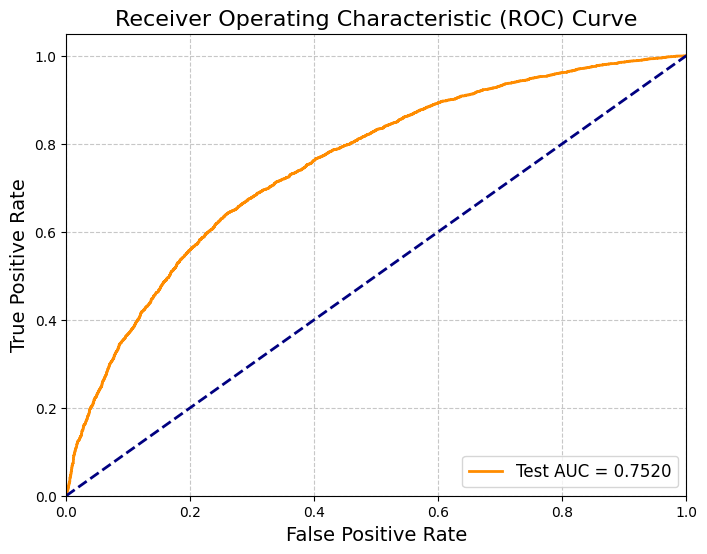

In [ ]:
# Calculate the probabilities for the test set
test_probs = rf_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve and AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test AUC = %0.4f' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score as f1, \
                            precision_score as precision, recall_score as recall
from sklearn.model_selection import cross_val_score

In [ ]:
logistic_model = LogisticRegression()
random_forest_model = RandomForestClassifier()
gradient_boosting_model = GradientBoostingClassifier()

PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# PCA Transformation
pca = PCA(n_components=75)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Training the MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp.fit(X_train_pca, y_train)

# Accuracy on the test set
accuracy = mlp.score(X_test_pca, y_test)

# Predicting probabilities on the test set for AUC-ROC
y_pred_probs = mlp.predict_proba(X_test_pca)[:, 1]

# Calculating AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_probs)

print(f"Accuracy: {accuracy}, AUC-ROC: {roc_auc}")

Accuracy: 0.5557962143327997, AUC-ROC: 0.5997770206799561


ANOVA F-Test

In [ ]:
# Select top k features based on the ANOVA F-test

selector = SelectKBest(f_classif, k=100)
X_new = selector.fit_transform(X, y)

In [ ]:
X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(X_new, y, test_size=0.2, random_state=42)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp.fit(X_train_F, y_train_F)

# Accuracy
accuracy = mlp.score(X_test_F, y_test_F)

# AUC-ROC
y_pred_probs = mlp.predict_proba(X_test_F)[:, 1]
roc_auc = roc_auc_score(y_test_F, y_pred_probs)

print(f"Accuracy: {accuracy}, AUC-ROC: {roc_auc}")

Accuracy: 0.5642715886618326, AUC-ROC: 0.5984852227301027


RFE

In [ ]:
log_reg = LogisticRegression()
rfe = RFE(estimator=log_reg, n_features_to_select=150)
rfe.fit(X_train, y_train)

#Transforming the training and test sets based on the features selected by RFE
X_train_mlp_selected = rfe.transform(X_train)
X_test_mlp_selected = rfe.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, activation='relu', random_state=42)

mlp.fit(X_train_mlp_selected, y_train)

MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)

In [ ]:
# For Accuracy
y_pred = mlp.predict(X_test)

# For AUC-ROC
y_pred_probs = mlp.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)

print(f"Accuracy: {accuracy}, AUC-ROC: {roc_auc}")

Accuracy: 0.5320651662115077, AUC-ROC: 0.4998353882198381


## Boosted Trees (XGBoost)

In [ ]:
## Calculate the sample weights
y_arr = np.array(y)

# Calculate the proportion of each class
class_weights = {
    0: len(y) / (2 * np.sum(y_arr == 0)),
    1: len(y) / (2 * np.sum(y_arr == 1))
}

# Assign weights to each instance in your target array
weights = np.array([class_weights[val] for val in y])
weights

array([0.93908522, 1.06936556, 0.93908522, ..., 1.06936556, 0.93908522,
       0.93908522])

### Step 1-Select Features Based on Correlation

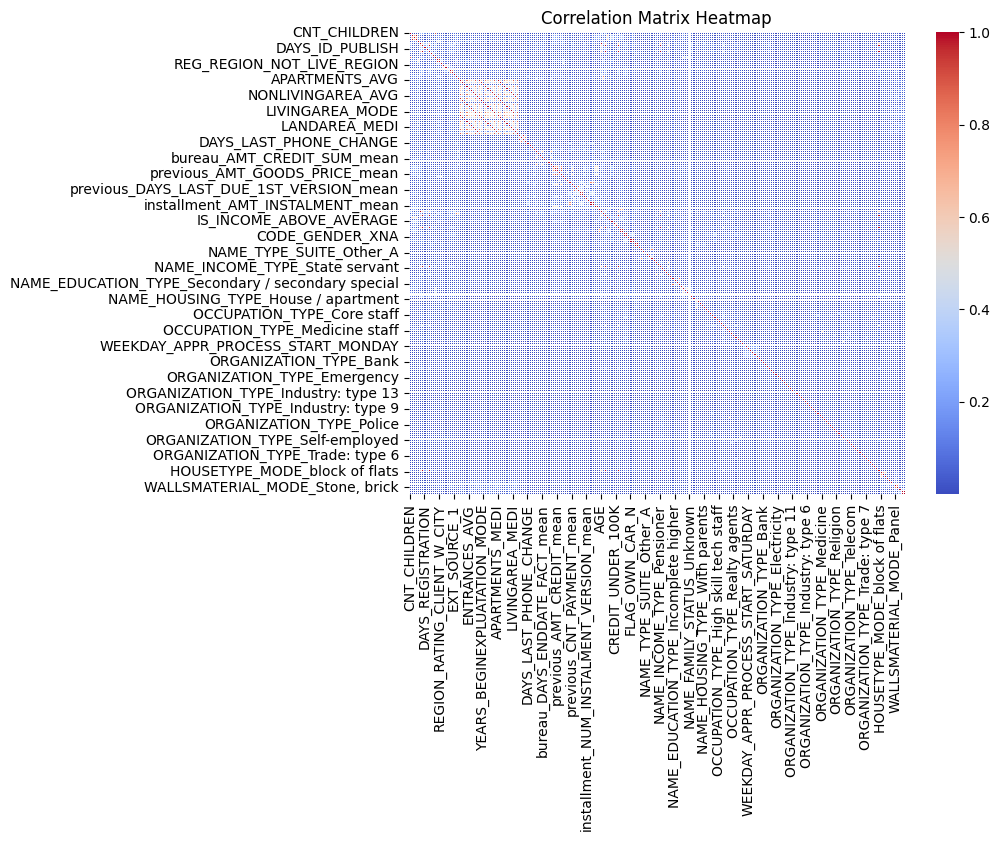

In [ ]:
# Calculate the correlation between features
correlation_matrix = X.corr().abs()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
# Create a Boolean mask to identify overly relevant features
high_correlation_mask = np.triu(correlation_matrix, k=1) > 0.8

# Due to the repeatability between rows and columns, use np.triu with where to get the upper triangular matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(np.bool))

# Drop over-correlated features to avoid multi-collinearity
to_drop = [col for col in upper.columns if any(upper[col] > 0.8)]
X_corr = X.drop(to_drop, axis=1)

In [ ]:
len(to_drop)

49

In [ ]:
X_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53094 entries, 0 to 53093
Columns: 187 entries, CNT_CHILDREN to EMERGENCYSTATE_MODE_No
dtypes: float64(61), uint8(126)
memory usage: 31.1 MB


### Step 2-Select Features Using ANOVA F-Test


In [ ]:
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_corr)

# Feature selection using ANOVA F-test
selector = SelectKBest(f_classif, k=75)  # Select 75 best features
X_anova = selector.fit_transform(X_corr, y)

# Get the selected feature names
selected_features_anova = X.columns[selector.get_support(indices=True)]
selected_features_anova.tolist()

['CNT_CHILDREN',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'BASEMENTAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'NONLIVINGAREA_AVG',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'LANDAREA_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'LANDAREA_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_Q

### Step 3-Select Features Using RFE
Note: runtime will be forever, because the underlying model used is gradient boosting. Constructing decision trees in RFE will be computationally more complicated than using the logistic model

In [ ]:
'''

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets, along with the weights
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb, weights_train, weights_test = train_test_split(
    X_corr, y, weights,   # I'm using X_corr here to avoid multi-collinearity
    test_size=0.2, random_state=42, stratify=y
)

rfe_xgb = RFE(estimator=gradient_boosting_model, n_features_to_select=150)
rfe_xgb.fit(X_train_xgb, y_train_xgb)
# Transforming the training and test sets based on the features selected by RFE
X_train_xgb_rfe_selected = rfe_xgb.transform(X_train_xgb)
X_test_xgb_rfe_selected = rfe_xgb.transform(X_test_xgb)

### Split Train and Test with Sample Weights

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets, along with the weights
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb, weights_train, weights_test = train_test_split(
    X_anova, y, weights,    # Change the X used here for different feature selection methods
    test_size=0.2, random_state=42, stratify=y
)

### XGBoost Model

In [ ]:
import xgboost as xgb

# Prepare DMatrix with weights for training and testing
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb, weight=weights_train)
dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb, weight=weights_test)

# Define the parameter dictionary for training
num_boost_round = 10
params = {
    'objective':'binary:logistic',
    'max_depth': 6,
    'alpha': 10,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Train the model
model_xgb = xgb.train(params, dtrain, num_boost_round)

In [ ]:
# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = model_xgb.predict(dtest)
y_pred_class = (y_pred > 0.5).astype("int32")

accuracy = accuracy_score(y_test_xgb, y_pred_class)
precision = precision_score(y_test_xgb, y_pred_class)
recall = recall_score(y_test_xgb, y_pred_class)
f1 = f1_score(y_test_xgb, y_pred_class)
roc_auc = roc_auc_score(y_test_xgb, y_pred)

print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")
print(f"ROC-AUC Score: {roc_auc:.6f}")

Accuracy: 0.674922
Precision: 0.648421
Recall: 0.665660
F1 Score: 0.656927
ROC-AUC Score: 0.731503


## Neural Network

**NEURAL NETWORK #1**

In [ ]:
#NORMALIZATION AND STANDARDIZATION

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

#DATA SPLITTING
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

#MODEL BUILDING
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#TRAINING

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# MODEL EVALUATION
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")


Epoch 1/20
996/996 [==============================] - 4s 3ms/step - loss: 0.6353 - accuracy: 0.6545 - val_loss: 0.6019 - val_accuracy: 0.6770
Epoch 2/20
996/996 [==============================] - 3s 3ms/step - loss: 0.5955 - accuracy: 0.6859 - val_loss: 0.5985 - val_accuracy: 0.6804
Epoch 3/20
996/996 [==============================] - 3s 3ms/step - loss: 0.5870 - accuracy: 0.6920 - val_loss: 0.5954 - val_accuracy: 0.6829
Epoch 4/20
996/996 [==============================] - 4s 4ms/step - loss: 0.5802 - accuracy: 0.6972 - val_loss: 0.5943 - val_accuracy: 0.6826
Epoch 5/20
996/996 [==============================] - 3s 3ms/step - loss: 0.5762 - accuracy: 0.7011 - val_loss: 0.5947 - val_accuracy: 0.6812
Epoch 6/20
996/996 [==============================] - 3s 3ms/step - loss: 0.5699 - accuracy: 0.7036 - val_loss: 0.5961 - val_accuracy: 0.6822
Epoch 7/20
996/996 [==============================] - 3s 3ms/step - loss: 0.5664 - accuracy: 0.7052 - val_loss: 0.5973 - val_accuracy: 0.6839
Epoch 

**NN #2**

In [ ]:
#MODEL BUILD 2

model_complex = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_complex.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
history_complex = model_complex.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# MODEL EVALUATION

y_pred = model_complex.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")



Epoch 1/20
996/996 [==============================] - 5s 4ms/step - loss: 0.6242 - accuracy: 0.6588 - val_loss: 0.5999 - val_accuracy: 0.6784
Epoch 2/20
996/996 [==============================] - 5s 5ms/step - loss: 0.5953 - accuracy: 0.6867 - val_loss: 0.5979 - val_accuracy: 0.6818
Epoch 3/20
996/996 [==============================] - 5s 5ms/step - loss: 0.5862 - accuracy: 0.6941 - val_loss: 0.5994 - val_accuracy: 0.6843
Epoch 4/20
996/996 [==============================] - 4s 4ms/step - loss: 0.5823 - accuracy: 0.6980 - val_loss: 0.5943 - val_accuracy: 0.6861
Epoch 5/20
996/996 [==============================] - 4s 4ms/step - loss: 0.5753 - accuracy: 0.7001 - val_loss: 0.5937 - val_accuracy: 0.6839
Epoch 6/20
996/996 [==============================] - 6s 6ms/step - loss: 0.5691 - accuracy: 0.7057 - val_loss: 0.5967 - val_accuracy: 0.6793
Epoch 7/20
996/996 [==============================] - 4s 4ms/step - loss: 0.5622 - accuracy: 0.7105 - val_loss: 0.5974 - val_accuracy: 0.6807
Epoch 

**NN #3** - SMOTE FOR BALANCING

In [ ]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# BUILD
model_complex_SMOTE = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_smote.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_complex_SMOTE.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training with balanced dataset
history_complex_SMOTE = model_complex_SMOTE.fit(X_train_smote, y_train_smote, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# MODEL EVALUATION
y_pred = model_complex_SMOTE.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")

Epoch 1/20
1061/1061 [==============================] - 6s 5ms/step - loss: 0.6226 - accuracy: 0.6621 - val_loss: 0.6053 - val_accuracy: 0.6733
Epoch 2/20
1061/1061 [==============================] - 6s 6ms/step - loss: 0.5929 - accuracy: 0.6908 - val_loss: 0.6048 - val_accuracy: 0.6811
Epoch 3/20
1061/1061 [==============================] - 5s 5ms/step - loss: 0.5827 - accuracy: 0.6982 - val_loss: 0.5923 - val_accuracy: 0.6864
Epoch 4/20
1061/1061 [==============================] - 4s 4ms/step - loss: 0.5767 - accuracy: 0.7010 - val_loss: 0.5935 - val_accuracy: 0.6818
Epoch 5/20
1061/1061 [==============================] - 7s 6ms/step - loss: 0.5694 - accuracy: 0.7080 - val_loss: 0.5975 - val_accuracy: 0.6813
Epoch 6/20
1061/1061 [==============================] - 5s 5ms/step - loss: 0.5627 - accuracy: 0.7121 - val_loss: 0.5967 - val_accuracy: 0.6868
Epoch 7/20
1061/1061 [==============================] - 5s 5ms/step - loss: 0.5555 - accuracy: 0.7171 - val_loss: 0.5954 - val_accuracy:

NEURAL NETWORK x RANDOM FOREST ENSEMBLE

In [ ]:
model_nn = model_complex_SMOTE

from sklearn.ensemble import RandomForestClassifier


# Train Random Forest model
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# predictions
nn_predictions = model_nn.predict(X_test)
rf_predictions = model_rf.predict_proba(X_test)[:, 1]

#Combine Predictions and Create New Feature Set
combined_features = np.column_stack((nn_predictions, rf_predictions))


from sklearn.linear_model import LogisticRegression

final_model = LogisticRegression()
final_model.fit(combined_features, y_test)

# Final predictions
final_predictions = final_model.predict(combined_features)

metrics_rf_nn = {
    'accuracy': accuracy_score(y_test, final_predictions),
    'precision': precision_score(y_test, final_predictions),
    'recall': recall_score(y_test, final_predictions),
    'f1_score': f1_score(y_test, final_predictions),
    'roc_auc': roc_auc_score(y_test, final_predictions)
}
metrics_rf_nn

332/332 [==============================] - 1s 2ms/step


{'accuracy': 0.6880120538657124,
 'precision': 0.6766363242306025,
 'recall': 0.6316002427675501,
 'f1_score': 0.6533430992989432,
 'roc_auc': 0.6843695364648181}

NEURAL NETWORK x G-BOOST ENSEMBLE

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Train a Gradient Boosting model
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train, y_train)

# Get predictions
gb_predictions = model_gb.predict_proba(X_test)[:, 1]

# Combine predictions
combined_features_gb = np.column_stack((nn_predictions, gb_predictions))

# Train final model
final_model_gb = LogisticRegression()
final_model_gb.fit(combined_features_gb, y_test)

# Final predictions
final_predictions_gb = final_model_gb.predict(combined_features_gb)

# For Gradient Boosting + Neural Network
metrics_gb_nn = {
    'accuracy': accuracy_score(y_test, final_predictions_gb),
    'precision': precision_score(y_test, final_predictions_gb),
    'recall': recall_score(y_test, final_predictions_gb),
    'f1_score': f1_score(y_test, final_predictions_gb),
    'roc_auc': roc_auc_score(y_test, final_predictions_gb)
}
metrics_gb_nn

{'accuracy': 0.7001600904039929,
 'precision': 0.690905144345561,
 'recall': 0.6439409265628161,
 'f1_score': 0.6665968586387434,
 'roc_auc': 0.6965300122595616}